# Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"

Nhóm 2:
1. 18120625 - Nguyễn Trần Trung - [Trung-Rei](https://github.com/Trung-Rei)
2. 18120658 - Phạm Viết Xuân - [PhamVietXuan](https://github.com/PhamVietXuan)
3. 1712698 - Võ Văn Quân - [quanvovan](https://github.com/quanvovan)
4. 1712160 - Hà Thị Ngọc Thắm - [Thamha09081999](https://github.com/Thamha09081999)

Link thùng chứa Github của nhóm: [link](https://github.com/Trung-Rei/kaggle-porto-seguro)

## Mô tả bài toán

Bảo hiểm là một thứ bắt buộc khi mua một chiếc xe ô tô. Thông thường, mức chi phí đóng bảo hiểm sẽ bằng nhau. Nhưng có những người chạy xe cẩn thận, cũng có người chạy xe hay va chạm khiến cho chi phí đóng bảo hiểm cho người người như vậy không công bằng. Như vậy, cần có một mức giá khác nhau cho những người lái xe khác nhau để công bằng với khách hàng cũng như công ty bảo hiểm.

Porto Seguro - Một công ty bảo hiểm lớn ở Brazil yêu cầu một mô hình học máy tốt để dự đoán **xác suất yêu cầu bồi thường** của chủ xe nhằm đưa ra mức giá bảo hiểm hợp lý hơn.

Input/Output:
* Input: Dữ liệu lịch sử được công ty thu thập từ chủ ô tô (chủ hợp đồng bảo hiểm) từ các năm trước.
* Output: Xác suất chủ xe đó yêu cầu bồi thường bảo hiểm. Giá trị từ 0 - 1; càng về 0 có nghĩa khả năng cao chủ ô tô đó sẽ không yêu cầu bồi thường cho năm sau; càng về 1 nghĩa là chủ xe khả năng cao năm sau đòi bồi thường bảo hiểm.

Link bài toán: [Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview)

### Độ đo đánh giá

* Metric: Normalized Gini Coefficient
* Cách tính: `2 * AUC – 1`
* Giá trị trong khoảng **(0, 1)**: càng về 1 mô hình càng tốt
* Phù hợp với bài toán phân lớp nhị phân và dữ liệu mất cân bằng nghiêm trọng (Giống **AUC**).

Giải thích cụ thể về **Normalized Gini Coefficient**: [link](https://luckytoilet.wordpress.com/2018/04/04/useful-properties-of-roc-curves-auc-scoring-and-gini-coefficients/?fbclid=IwAR1Md3U9Wk6E43cxV56NWxWroIGcRgGQJ7cnTZWJd9orSvbSYkiBcMhqxEs)

## Giải quyết bài toán

Tổng quan solution: Ensemble 2 mô hình LightGBM và Neural Networks. Mỗi mô hình có Feature engineering riêng. Kết quả cuối cùng lấy trung bình có trọng số của 2 mô hình.

Lý do chọn:
* Học được nhiều kỹ thuật FE thông dụng trên dữ liệu dạng bảng (feature crossing, feature interacting, feature selection,...).
* Học được cách làm việc trên data có đặc trưng ẩn danh (phổ biến trên thực tế).
* Sử dụng các mô hình LightGBM, XGBoost (là các mô hình được sử dụng rất nhiều trong các cuộc thi trên Kaggle).

Tuần này: Tiếp tục tìm hiểu kỹ hơn các kỹ thuật FE được sử dụng + đặc trưng XGBoost.

### Import thư viện

In [ ]:
import lightgbm as lgbm
from scipy import sparse as ssp
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
from feature_generater import Multiply_Divide, Series_string, Features_Counts, Statistic_features
from scipy import sparse
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["font.size"] = 14

import warnings
warnings.filterwarnings("ignore")

#for NN model
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, merge, Concatenate, concatenate
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from time import time
import datetime
from sklearn.model_selection import StratifiedKFold


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Tổng quan dữ liệu

Thông tin dữ liệu từ cuộc thi được bảo mật nên tên các đặc trưng được thay thế bằng tên ẩn danh.

Các thông tin được cuộc thi cung cấp:
* Đặc trưng được chia làm 4 nhóm chính:
    * `ind` (individual): các đặc trưng liên quan đến người lái xe.
    * `reg` (region): các đặc trưng về khu vực người đó chạy xe.
    * `car` (car): các đặc trưng thông số của ô tô.
    * `calc` (calculated): các đặc trưng đã được tính toán.
* Hậu tố `cat` cho đặc trưng **categorical**, `bin` cho đặc trưng **nhị phân**, không có hậu tố chỉ những đặc trưng **ordinal** hoặc **continuous**.
* Giá trị `-1` đại diện cho dữ liệu tại đó bị thiếu.
* Cột `target`: gồm giá trị 1 và 0 thể hiện chủ xe đó có đưa ra yêu cầu bồi thường hay không.

In [ ]:
path = "./drive/MyDrive/2021 - 2022/KHDLUD/Final project/input"

train = pd.read_csv(path+'train.csv')
train_label = train['target']
train_id = train['id']
test = pd.read_csv(path+'test.csv')
test_id = test['id']

In [ ]:
train.sample(5)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
179332,1102254,0,0,2,1,1,0,1,0,0,0,0,0,0,0,0,11,1,0,0,0.1,0.2,-1.000000,5,1,0,0,1,11,1,1,2,1,19,3,0.316228,0.626053,0.318591,2.828427,0.8,0.2,0.8,3,2,9,4,10,2,7,8,2,5,12,0,1,0,0,1,0
74762,840860,1,5,1,4,1,0,0,0,1,0,0,0,0,0,0,7,1,0,0,0.9,0.2,0.509902,11,0,-1,0,-1,10,1,1,2,1,89,2,0.387298,1.024614,0.408656,3.605551,0.3,0.9,0.6,1,2,8,4,9,0,7,4,1,1,9,0,0,1,0,0,0
125989,968878,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,5,1,0,0,0.9,0.2,0.682825,10,1,-1,0,1,1,1,1,0,1,74,3,0.374166,0.642358,0.386135,2.449490,0.1,0.0,0.4,2,3,6,3,9,1,11,7,1,2,8,0,1,0,1,1,0
1840,658753,0,5,1,6,1,0,0,1,0,0,0,0,0,0,0,6,1,0,0,0.9,0.6,0.918899,11,1,-1,1,-1,16,1,1,2,1,104,3,0.316228,0.899977,0.367423,3.464102,0.0,0.3,0.0,1,0,8,3,9,2,8,2,3,3,8,0,1,1,0,0,0
241326,1257126,0,7,1,3,1,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.9,1.2,1.694292,0,0,-1,9,1,9,0,1,0,1,104,3,0.515364,1.185484,0.506754,3.162278,0.4,0.6,0.6,3,1,9,4,11,4,8,4,1,2,6,0,0,0,0,0,0


In [ ]:
train.shape

(333446, 59)

In [ ]:
test.shape

(442831, 58)

In [ ]:
train.drop_duplicates()
train.shape

(333446, 59)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333446 entries, 0 to 333445
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              333446 non-null  int64  
 1   target          333446 non-null  int64  
 2   ps_ind_01       333446 non-null  int64  
 3   ps_ind_02_cat   333446 non-null  int64  
 4   ps_ind_03       333446 non-null  int64  
 5   ps_ind_04_cat   333446 non-null  int64  
 6   ps_ind_05_cat   333446 non-null  int64  
 7   ps_ind_06_bin   333446 non-null  int64  
 8   ps_ind_07_bin   333446 non-null  int64  
 9   ps_ind_08_bin   333446 non-null  int64  
 10  ps_ind_09_bin   333446 non-null  int64  
 11  ps_ind_10_bin   333446 non-null  int64  
 12  ps_ind_11_bin   333446 non-null  int64  
 13  ps_ind_12_bin   333446 non-null  int64  
 14  ps_ind_13_bin   333446 non-null  int64  
 15  ps_ind_14       333446 non-null  int64  
 16  ps_ind_15       333446 non-null  int64  
 17  ps_ind_16_

0    0.96349
1    0.03651
Name: target, dtype: float64


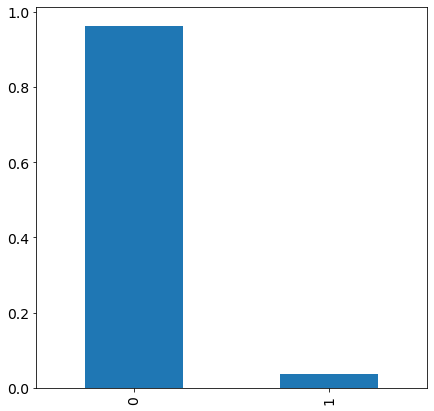

In [ ]:
cls_ratio = train_label.value_counts()/train_label.count()
print(cls_ratio)
cls_ratio.plot.bar()
plt.show()

* Tập **train** có 59 cột, tập **test** có 58 cột (không có cột `target`)
* Tập **train** không có dòng trùng nhau.
* Toàn bộ dữ liệu đều ở dạng số.
* Dữ liệu mất cân bằng nghiêm trọng với `96.3%` lớp 0 và `3.6%` lớp 1.

### Feature engineer + Khám phá dữ liệu (LightGBM)

Bao gồm:
* Loại bỏ tất cả đặc trưng `calc`
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Mã hóa one hot với các đặc trưng `cat`
* Gộp các đặc trưng `ind` làm một: `new_ind` (feature crossing)
* Đếm các đặc trưng `cat` kể cả `new_ind` (count/frequency encoding)

#### Loại bỏ các đặc trưng `calc`

Các đặc trưng `calc` được loại bỏ vì tác giả thấy chúng không đóng góp gì cho model qua các thử nghiệm.

In [ ]:
y = train['target'].values
drop_feature = [
    'id',
    'target'
]

X = train.drop(drop_feature,axis=1)
feature_names = X.columns.tolist()
cat_features = [c for c in feature_names if ('cat' in c and 'count' not in c)]
num_features = [c for c in feature_names if ('cat' not in c and 'calc' not in c)]

In [ ]:
cat_features

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [ ]:
num_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

#### Đếm số lượng giá trị thiếu mỗi dòng

Thêm cột `missing`: số lượng giá trị thiếu của mỗi dòng dữ liệu.

In [ ]:
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)
num_features.append('missing')

In [ ]:
train["missing"].value_counts()

2.0    254982
1.0    156295
0.0    124931
3.0     56042
4.0      2883
7.0        53
6.0        19
8.0         7
Name: missing, dtype: int64

Theo một notebook **EDA** được public trong cuộc thi ([link](https://www.kaggle.com/bertcarremans/data-preparation-exploration#Exploratory-Data-Visualization)): trong các đặc trưng có giá trị thiếu, tỷ lệ lớp dương của giá trị thiếu có xu hướng cao hơn hoặc thấp hơn rất nhiều so với tỷ lệ lớp dương toàn dữ liệu. Có vẻ như những chủ xe có giá trị thiếu có khả năng cao hơn sẽ đưa ra yêu cầu bồi thường (hoặc thấp hơn trong vài trường hợp).

=> Số lượng giá trị thiếu có thể là một đặc trưng tốt.

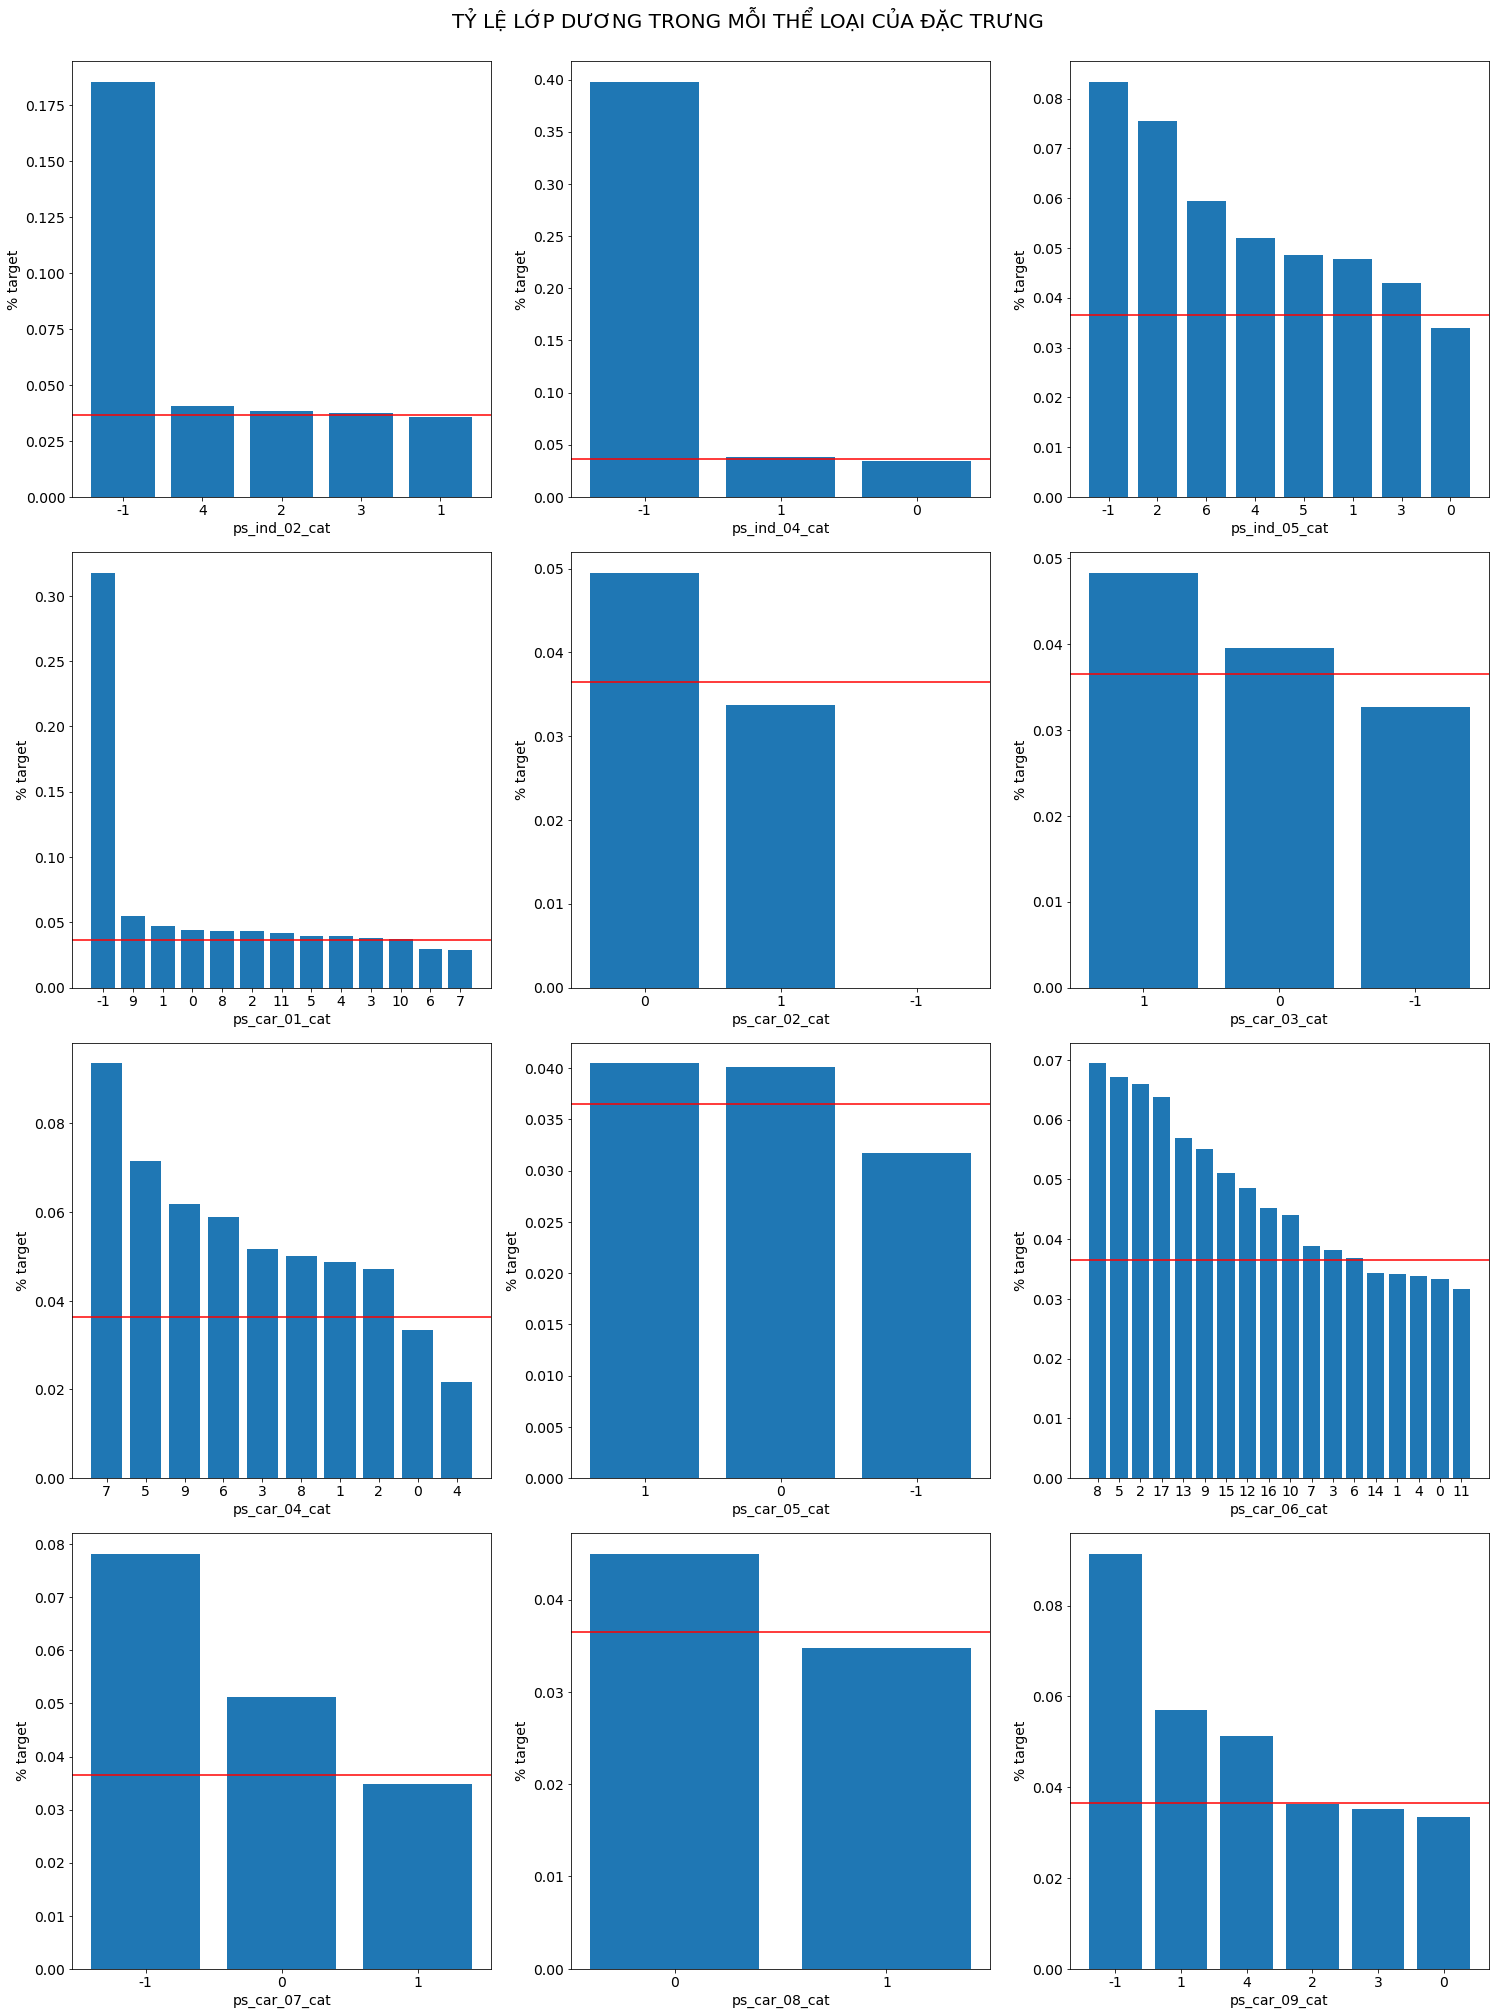

In [ ]:
positive_ratio = train["target"].mean()

fig, axes = plt.subplots(4, 3, figsize=(21,28))
fig.suptitle("TỶ LỆ LỚP DƯƠNG TRONG MỖI THỂ LOẠI CỦA ĐẶC TRƯNG", y=1, fontsize=20)
axes = axes.flatten()
for f, ax in zip(cat_features[:-2], axes):
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    ax.bar(cat_perc[f].apply(str), cat_perc["target"])
    ax.set(xlabel=f, ylabel='% target')
    ax.axhline(y=positive_ratio, color="r")
plt.tight_layout()
plt.show();

#### Chuyển các đặc trưng categorical sang dạng `one hot`

Các trị null `-1` không được **impute** (điền giá trị mean hoặc mode) mà được xem như là một **giá trị thể loại** và được encode.

Suy đoán: Việc xem `null` như giá trị có thể là một ý hay.

In [ ]:
for c in cat_features:
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    test[c] = le.transform(test[c])

enc = OneHotEncoder()
enc.fit(train[cat_features])
X_cat = enc.transform(train[cat_features])
X_t_cat = enc.transform(test[cat_features])

#### Gộp các đặc trưng `ind` làm một (feature crossing)

Trên thực tế, các đặc trưng thường có mối quan hệ với nhau. Đôi khi những quan hệ này có ích nhưng một số mô hình học máy lại không nắm bắt được. Vì vậy việc thêm các mối quan hệ này như một đặc trưng mới có thể giúp mô hình tăng khả năng dự đoán. Thông thường các mối quan hệ được suy ra từ kiến thức miền (domain knowledge), hoặc được tìm ra bằng các kỹ thuật FE.

Đọc thêm: [link](https://machinelearningcoban.com/tabml_book/ch_data_processing/crossing.html)

Ở đây, ta gộp các đặc trưng `ind` thành một đặc trưng mới `new_ind`. Như vậy, các dòng có bộ giá trị đặc trưng từ `ind_01` đến `ind_18` giống nhau sẽ có giá trị `new_ind` cũng giống nhau. Đặc trưng mới này thể hiện được sự xảy ra đồng thời của các giá trị của các đặc trưng riêng lẻ.

In [ ]:
ind_features = [c for c in feature_names if 'ind' in c]
count=0
for c in ind_features:
    if count==0:
        train['new_ind'] = train[c].astype(str)+'_'
        test['new_ind'] = test[c].astype(str)+'_'
        count+=1
    else:
        train['new_ind'] += train[c].astype(str)+'_'
        test['new_ind'] += test[c].astype(str)+'_'

In [ ]:
train["new_ind"]

0          2_2_5_2_1_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_1_1_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_1_1_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_2_1_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
595207    3_1_10_1_1_0_0_0_1_0_0_0_0_0_13_1_0_0_
595208      5_1_3_1_1_0_0_0_1_0_0_0_0_0_6_1_0_0_
595209    1_1_10_1_1_1_0_0_0_0_0_0_0_0_12_1_0_0_
595210     5_2_3_2_1_0_0_1_0_0_0_0_0_0_12_1_0_0_
595211      0_1_8_1_1_1_0_0_0_0_0_0_0_0_7_1_0_0_
Name: new_ind, Length: 595212, dtype: object

In [ ]:
train["new_ind"].unique().shape[0]

93282

#### Đếm các đặc trưng `cat` kể cả `new_ind` (count/frequency encoding)

count/frequency encoding:
* Mã hóa một giá trị bằng số lần xuất hiện giá trị đó trong cột đặc trưng.
* Được sử dụng nhiều trong các cuộc thi Kaggle. Nhiều khi làm tăng khả năng dự đoán của mô hình.
* Bao gồm cả thông tin về tần suất xuất hiện của giá trị. Đôi khi thông tin này có ích cho việc dự đoán.
* Không như one hot, count encoding chỉ mã hóa đặc trưng bằng 1 cột -> lựa chọn tốt đối với các đặc trưng có số lượng giá trị lớn (the curse of dimensionality).

Đọc thêm: [link](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)

Thực hiện **count encoding** trên các đặc trưng `cat` bên cạnh **one hot encoding** (hậu tố `_count`).

Đặc trưng `new_ind` có số lượng giá trị phân biệt lớn nên cũng sẽ sử dụng mã hóa count.

Số lượng được count trên bộ dữ liệu gộp giữa **train** và **test** -> Để có số liệu thống kê tổng quát hơn.


In [ ]:
cat_count_features = []
for c in cat_features+['new_ind']:
    d = pd.concat([train[c],test[c]]).value_counts().to_dict()
    train['%s_count'%c] = train[c].apply(lambda x:d.get(x,0))
    test['%s_count'%c] = test[c].apply(lambda x:d.get(x,0))
    cat_count_features.append('%s_count'%c)

In [ ]:
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'new_ind_count']

In [ ]:
train_list = [train[num_features+cat_count_features].values,X_cat,]
test_list = [test[num_features+cat_count_features].values,X_t_cat,]

X = ssp.hstack(train_list).tocsr()
X_test = ssp.hstack(test_list).tocsr()

### Train LightGBM

#### Giới thiệu LightGBM

Gradient boosting:
* **Ensemble** của một chuỗi các mô hình. Mô hình sau sẽ học cách cải thiện lỗi của các mô hình trước.
* **Gradient boosting**: sử dụng **gradient descent** để boost.

<img src="https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/1.png?raw=1" alt="1" width="1000"/>

Nguồn: [Link](https://youtu.be/iMal3Trpg2Y)



LightGBM (Lightweight Gradient Boosting Model):
* Một framework được phát triển bởi Microsoft.
* Một trong những thuật toán ensemble được ưa chuộng nhất.
* Base model dựa trên **Decision tree**, sử dụng **Gradient boosting**.

Điểm mạnh của LightGBM so với các model khác:
* Công việc tốn thời gian nhất các mô hình GBM là việc tìm kiếm **split points** (điểm phân chia quyết định). Sử dụng **histogram-based algorithms** (thực hiện rời rạc hóa đặc trưng liên tục thành các bin) giúp tăng tốc việc tìm kiếm và giảm bộ nhớ sử dụng.
* Đặc biệt, LightGBM sử dụng 2 thuật toán **GOSS** (Gradient Based One Side Sampling) và **EFB** (Exclusive Feature Bundling) giúp tăng tốc đáng kể quá trình này. ([link](https://programmersought.com/article/98713401245/))
* Phát triển cây dựa trên **leaf-wise** trong khi các mô hình khác sử dụng **level-wise** (**level-wise** phát triển leaf đồng thời trên cùng một độ sâu, dẫn tới nhiều node leaf có **split gain** thấp vẫn phải tách không cần thiết. **leaf-wise** chọn ra node leaf có **độ lỗi** lớn nhất để phát triển -> độ lỗi giảm mạnh hơn, tuy nhiên cây dễ phát triển quá sâu gây **overfit**, có thể giới hạn bằng `max_depth`).

<img src="https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/2.jpeg?raw=1" alt="2" width="1000"/>

#### Evaluation metric

In [ ]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]

    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]

    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)

    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)

    # normalize to true Gini coefficient
    return G_pred * 1. / G_true

cv_only = True
save_cv = True
full_train = False

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', Gini(labels, preds), True

#### Hyperparameter tuning

Huấn luyện sử dụng **k-fold cross validation** (5-fold):
* Xáo trộn và chia tập train thành 5 phần bằng nhau.
* Với mỗi phần ta lấy 4 phần còn lại làm tập train để dự đoán. Đồng thời dự đoán cho cả tập test.
* Ghép các dự đoán của các phần **validate** lại để có được kết quả đánh giá CV.
* Đối với tập test, ta lấy trung bình của 5 lần dự đoán làm kết quả cuối cùng.

<img src="https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/3.jpeg?raw=1" alt="3" width="1000"/>

In [ ]:
ORIGINAL_PARAMS = {'num_leaves': 15,
                   'feature_fraction': 0.6,
                   'min_child_samples': 10,
                   'min_child_weight': 150}

Optuna:
* là 1 framework điều chỉnh siêu tham số tự động được sử dụng phổ biến trên Kaggle.
* Sử dụng tối ưu Bayesian (**Bayesian optimization**). Ý tưởng là dựa vào kết quả từ các lần đánh giá trước để đưa ra bộ tham số tiếp theo phù hợp. Nhờ vậy có thể nhanh chóng tìm ra bộ tham số tối ưu.
* Sử dụng Optuna: [link](https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c)


Vấn đề:
* Tập train lớn, việc tune tham số rất mất thời gian.
* Dùng một phần nhỏ data thì nhanh hơn, nhưng kết quả có thể sẽ không đúng với tập gốc.

Ý tưởng của nhóm:
* Chia tập train làm 2 phần: 30% dùng để thực hiện cross validate, 70% còn lại để đánh giá.
* Mỗi lần train của CV sẽ dự đoán trên phần test. Kết quả cuối cùng là trung bình cộng của 5 lần. Đánh giá trên kết quả này để chọn siêu tham số.
* Việc tuning sẽ nhanh hơn, đánh giá cũng tổng quát hơn.

<img src="https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/4.png?raw=1" alt="4" width="1000"/>

Trong solution của tác giả:
* Thực hiện huấn luyện cùng một bộ siêu tham số trên 16 random seed khác nhau (0-15) và lấy trung bình -> Tăng tính ổn định của kết quả.


Hướng cải tiến của nhóm:
* Qua thực nghiệm, ta thấy cùng một bộ siêu tham số có thể cho kết quả cao hơn ở seed này nhưng thấp hơn ở seed khác.
* Nếu ta tìm bộ siêu tham số riêng cho từng seed thì sao?
* Chọn ngẫu nhiên 5 seed (0, 2, 5, 7, 12). Tìm bộ tham số tối ưu cho mỗi seed. Cuối cùng lấy trung bình toàn bộ.

In [ ]:
from sklearn.model_selection import train_test_split

tune_X, tune_X_test, tune_y, tune_y_test = train_test_split(X, train_label, test_size=0.7, random_state=218, stratify=train_label)

In [ ]:
!pip install optuna

In [ ]:
from optuna.integration import LightGBMPruningCallback
import optuna

In [ ]:
def objective(trial, X, y, X_test, y_test):
    param_grid = {
        'objective': 'binary',
        'verbosity': 0,
        'num_boost_round': 10000,
        "num_leaves": trial.suggest_int("num_leaves", 5, 55, step=5),
        "min_child_samples": trial.suggest_int("min_child_samples", 0, 150, step=10),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 200.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
        "seed": 12,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=218)

    cv_train = np.zeros(len(y))
    cv_pred = np.zeros(len(y_test))

    kf = cv.split(X, y)

    best_trees = []
    fold_scores = []

    for i, (train_fold, validate) in enumerate(kf):
        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], y[train_fold], y[validate]
        dtrain = lgbm.Dataset(X_train, label_train)
        dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
        bst = lgbm.train(param_grid, dtrain, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                         early_stopping_rounds=100,
                         callbacks=[LightGBMPruningCallback(trial, "gini")])
        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)

        score = Gini(label_validate, cv_train[validate])
        print(score)
        fold_scores.append(score)

    cv_pred /= 5

    print("cv score:")
    cv_score = Gini(y, cv_train)
    print(cv_score)
    print(fold_scores)
    print("test_score")
    test_score = Gini(y_test, cv_pred)
    print(test_score)
    print(best_trees, np.mean(best_trees))

    return test_score

In [ ]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, tune_X, tune_y.values, tune_X_test, tune_y_test)
study.optimize(func, n_trials=10)

In [ ]:
print(f"\tBest value: {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

#### Train

**Private score** | **Public score**

Score của tác giả (thời gian train trên Colab là hơn 1 tiếng)

![5](https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/5.png?raw=1)

Score của nhóm (train 5 seed với thời gian ít hơn 30 phút)

![6](https://github.com/Trung-Rei/kaggle-porto-seguro/blob/main/6.png?raw=1)

In [ ]:
FIXED_PARAMS = {'objective': 'binary', 'verbosity': 0, 'num_boost_round': 10000}

SEARCH_PARAMS =     [{'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 100,
                    'min_child_weight': 101.94095152382667,
                    'seed': 0},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 60,
                    'min_child_weight': 124.66803210058042,
                    'seed': 2},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 150,
                    'min_child_weight': 148.13731979766956,
                    'seed': 5},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 30,
                    'min_child_weight': 157.2373873709297,
                    'seed': 7},
                    {'num_leaves': 15,
                    'feature_fraction': 0.5,
                    'min_child_samples': 10,
                    'min_child_weight': 125.16184758062035,
                    'seed': 12}]

In [ ]:
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

In [ ]:
num_seed = len(SEARCH_PARAMS)
x_score = []
final_cv_train = np.zeros(len(train_label))
final_cv_pred = np.zeros(len(test_id))
for s_param in SEARCH_PARAMS:
    cv_train = np.zeros(len(train_label))
    cv_pred = np.zeros(len(test_id))

    params = {**s_param, **FIXED_PARAMS}

    if cv_only:
        kf = kfold.split(X, train_label)

        best_trees = []
        fold_scores = []

        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                X[train_fold, :], X[validate, :], train_label[train_fold], train_label[validate]
            dtrain = lgbm.Dataset(X_train, label_train)
            dvalid = lgbm.Dataset(X_validate, label_validate, reference=dtrain)
            bst = lgbm.train(params, dtrain, valid_sets=dvalid, feval=evalerror, verbose_eval=100,
                            early_stopping_rounds=100)
            best_trees.append(bst.best_iteration)
            cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
            cv_train[validate] += bst.predict(X_validate)

            score = Gini(label_validate, cv_train[validate])
            print(score)
            fold_scores.append(score)

        cv_pred /= NFOLDS
        final_cv_train += cv_train
        final_cv_pred += cv_pred

        print("cv score:")
        print(Gini(train_label, cv_train))
        #print("current score:", Gini(train_label, final_cv_train / (s + 1.)), s+1)
        print(fold_scores)
        print(best_trees, np.mean(best_trees))

        x_score.append(Gini(train_label, cv_train))

print(x_score)
pd.DataFrame({'id': test_id, 'target': final_cv_pred / num_seed}).to_csv('./lgbm3_pred_avg.csv', index=False)
pd.DataFrame({'id': train_id, 'target': final_cv_train / num_seed}).to_csv('./lgbm3_cv_avg.csv', index=False)

### Feature engineer + Khám phá dữ liệu (Neural networks)

Bao gồm:
* Thêm đặc trưng: Số lượng giá trị thiếu mỗi dòng
* Thêm đặc trưng: Nhân và chia của 2 đặc trưng (feature interacting using Equations)
* Đếm giá trị các đặc trưng `cat`
* Thêm các đặc trưng Groupby (feature interacting using Groupby)
* Thêm đặc trưng được train bằng **XGBoost**

In [ ]:
#load data for train NN model
cv_only = True
save_cv = True

#read data
train = pd.read_csv("./drive/MyDrive/2021 - 2022/KHDLUD/Final project/input/train.csv")
train_label = train['target']
train_id = train['id']
del train['target'], train['id']

test = pd.read_csv("./drive/MyDrive/2021 - 2022/KHDLUD/Final project/input/test.csv")
test_id = test['id']
del test['id']



#### Đếm số lượng giá trị thiếu từng dòng

In [ ]:
#find missing value by each row and recode to column 'missing'
train['missing'] = (train==-1).sum(axis=1).astype(float)
test['missing'] = (test==-1).sum(axis=1).astype(float)


In [ ]:
#get all featrue name
feature_names = list(train) 

# extract feature with cat, bin, num, inter
cat_fea = [x for x in list(train) if 'cat' in x]
bin_fea = [x for x in list(train) if 'bin' in x]
num_features = [c for c in list(train) if ('cat' not in c and 'calc' not in c)]
inter_fea = [x for x in list(train) if 'inter' in x]

#### Nhân và chia đặc trưng (feature interacting using Equations)

Nhiều mô hình học máy có cách làm riêng để kết hợp các đặc trưng với nhau (như NN sẽ là tổng có trọng số các đặc trưng). Tuy nhiên, kinh nghiệm cho thấy ta vẫn nên kết hợp các đặc trưng bằng tay thay vì dựa dẫm quá nhiều vào mô hình. Nếu cách kết hợp được chọn lựa tốt thì có thể sẽ giúp ta vươn xa trong các cuộc thi Kaggle.

Có rất nhiều cách kết hợp đặc trưng. Ngoài **domain knowledge**, ta có thể thử tất cả các cách kết hợp có thể. Để không tốn nhiều thời gian ta nên lựa chọn theo 3 tiêu chí sau:
* **effect sparsity**: càng ít feature được kết hợp với nhau, càng tăng tính hiệu quả của feature mới kết hơp. Thường chỉ cần từ 2 tới 3.
* **heredity**: feature mới kết hợp từ các feature riêng lẻ được cho là có tính hiệu quả chỉ khi ít nhất một feature thành phần có tính hiệu quả.
* **priority**: hầu hết các trường hợp, sẽ tốt hơn khi kết hợp các feature gốc chưa qua biến đổi (scale, log-transform,...).

Đọc thêm: [link](https://www.kaggle.com/milankalkenings/comprehensive-tutorial-feature-engineering) (mục `4. Combine Features`)

Ở đây ta sử dụng 2 cách kết hợp đặc trưng là tích và thương của 2 đặc trưng:
* Thực hiện trên một số đặc trưng quan trọng được lựa chọn bằng **feature selection**
* Số lượng đặc trưng: `6C2 * 2 = 30`
* Prefix: `inter_`


In [ ]:
#Add features of Multiply and Divide
features= ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01']
train, test, MD_features = Multiply_Divide(train, test, features)

In [ ]:
train[MD_features].head(5)

,inter_0*,inter_0/,inter_1*,inter_1/,inter_2*,inter_2/,inter_3*,inter_3/,inter_4*,inter_4/,inter_5*,inter_5/,inter_6*,inter_6/,inter_7*,inter_7/,inter_8*,inter_8/,inter_9*,inter_9/,inter_10*,inter_10/,inter_11*,inter_11/,inter_12*,inter_12/,inter_13*,inter_13/,inter_14*,inter_14/
0,4.418395,0.176736,0.634544,1.230630,9.720468,0.080334,0.618575,1.262398,1.767358,0.441839,3.590352,6.963106,55,0.454545,3.5,7.142857,10,2.5,7.898774,0.065279,0.502649,1.025815,1.436141,0.359035,7.7,15.714286,22,5.5,1.4,0.35
1,4.331716,0.088402,0.474062,0.807773,1.856450,0.206272,0.495053,0.773521,0.618817,0.618817,5.362544,9.137455,21,2.333333,5.6,8.750000,7,7.0,2.298233,0.255359,0.612862,0.957597,0.766078,0.766078,2.4,3.750000,3,3.0,0.8,0.80
2,5.774271,0.071287,-0.641586,-0.641586,7.699029,0.053465,0.000000,inf,3.207929,0.128317,-9.000000,-9.000000,108,0.750000,0.0,inf,45,1.8,-12.000000,-0.083333,-0.000000,-inf,-5.000000,-0.200000,0.0,inf,60,2.4,0.0,0.00
3,1.085898,0.271474,0.315425,0.934592,4.343590,0.067869,0.488654,0.603276,0.000000,inf,1.161895,3.442652,16,0.250000,1.8,2.222222,0,inf,4.647580,0.072618,0.522853,0.645497,0.000000,inf,7.2,8.888889,0,inf,0.0,inf
4,0.000000,inf,0.475728,0.673001,5.092484,0.062870,0.396082,0.808331,0.000000,inf,0.000000,0.000000,0,0.000000,0.0,0.000000,0,NaN,7.566827,0.093418,0.588531,1.201084,0.000000,inf,6.3,12.857143,0,inf,0.0,inf


#### Đếm các đặc trưng `cat`

* Gộp các đặc trưng của mỗi nhóm `ind`, `reg` và `car` với nhau thành 3 đặc trưng mới: `new_ind`, `new_reg`, `new_car`
* Đếm số lượng giá trị của các đặc trưng **categorical** (bao gồm 3 đặc trưng mới)

In [ ]:
'''
create 1_0_1_1..... data as new_xxx

new_ind: collect all data from all relative "ind" columns, then generate series number

new_reg, new_car for train and test data 
For RNN processing, generating a sequence number
'''

category_list = ['ind', 'reg', 'car']
#add 'new_ind','new_reg','new_car' in train and test dataset
train, test = Series_string(train,test,category_list )

In [ ]:
train[['new_ind','new_reg','new_car']].head(5)

,new_ind,new_reg,new_car
0,2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0,0.7_0.2_0.718070331,10_1_-1_0_1_4_1_0_0_1_12_2_0.4_0.883678918_0.3...
1,1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1,0.8_0.4_0.766077672,11_1_-1_0_-1_11_1_1_2_1_19_3_0.316227766_0.618...
2,5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0,0.0_0.0_-1.0,7_1_-1_0_-1_14_1_1_2_1_60_1_0.316227766_0.6415...
3,0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0,0.9_0.2_0.580947502,7_1_0_0_1_11_1_1_3_1_104_1_0.374165739_0.54294...
4,0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0,0.7_0.6_0.840758586,11_1_-1_0_-1_14_1_1_2_1_82_3_0.316069613_0.565...


In [ ]:
train.new_ind.unique().shape[0]

69259

In [ ]:
train.new_reg.unique().shape[0]

37842

In [ ]:
train.new_car.unique().shape[0]

241125

In [ ]:
'''
count_features

preparing for train[cat_count_features] 
cat_fea = 
['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat',
 'ps_car_03_cat','ps_car_04_cat','ps_car_05_cat','ps_car_06_cat','ps_car_07_cat',
 'ps_car_08_cat','ps_car_09_cat','ps_car_10_cat', 'ps_car_11_cat']

Example: 
ps_ind_02_cat_count
dictionay of ps_ind_02_cat 
([(1, 1079327), (2, 309747), (3, 70172), (4, 28259), (-1, 523)])

row        count     origial value
595202    1079327       1     
595203     309747       2
595204     309747       2
595205      70172       3
595206    1079327       1

''' 

cat_fea = [ name for name in list(train) if 'cat' in name and 'count' not in name]
features= cat_fea + ['new_ind','new_reg','new_car']

train, test, cat_count_features= Features_Counts(train, test, features)

In [ ]:
train[cat_count_features].head(5)

,ps_ind_02_cat_count,ps_ind_04_cat_count,ps_ind_05_cat_count,ps_car_01_cat_count,ps_car_02_cat_count,ps_car_03_cat_count,ps_car_04_cat_count,ps_car_05_cat_count,ps_car_06_cat_count,ps_car_07_cat_count,ps_car_08_cat_count,ps_car_09_cat_count,ps_car_10_cat_count,ps_car_11_cat_count,new_ind_count,new_reg_count,new_car_count
0,161661,323472,688215,64817,644368,536377,647175,225240,40452,721380,130298,253825,769774,9487,2,13,1
1,562890,452689,688215,270764,644368,536377,647175,347913,172119,721380,645979,460577,769774,6572,12,22,7
2,14862,323472,688215,234511,644368,536377,647175,347913,76913,721380,645979,460577,769774,10291,8,7128,22
3,562890,452689,688215,234511,644368,95487,647175,225240,172119,721380,645979,19437,769774,111215,604,112,1
4,161661,323472,688215,270764,644368,536377,647175,347913,76913,721380,645979,460577,769774,13654,59,14,4


#### Các đặc trưng Groupby (feature interacting using Groupby)

Đôi khi đặc trưng kết hợp dựa trên việc **groupby** feature này theo feature kia có thể tăng hiệu quả mô hình. Giả sử ta có 2 feature là `lương` nhân viên và `phòng ban` của họ. Bản thân `lương` đã là một đặc trưng tốt. Nhưng nếu ta so sánh `lương` người này với người kia trong chính `phòng ban` của họ, ta có thể hiểu được tại sao người này không hài lòng với công việc trong khi người kia thì hài lòng, cho dù `lương` của người này cao hơn nhiều so với người của `phòng ban` khác.

Đọc thêm: link ở trên.

Chọn 2 đặc trưng (`target_feature` và `group_feature`), gom nhóm `target_feature` theo `group_feature`.

Thực hiện các thống kê (count, min, max, median, mean, std) trên từng group.

Số lượng đặc trưng:
* 5 target_features, 6 group_features: 36 cách chọn
* 6 thống kê count, min, max, median, mean, std
* tổng số đặc trưng: `36 * 6 = 216`

Thống kê được thực hiện trên tập dữ diệu gộp của `train` và `test` -> tổng quát hơn.

In [ ]:
#feature aggregation
target_features = ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01']
group_features = ['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_15', 'ps_reg_01', 'ps_ind_01', 'ps_ind_05_cat']

#return numpy because we need to do np.hstack to merge all statistic feature together, so that it would return np array
train_statis, test_statis =  Statistic_features(train, test, target_features, group_features)

In [ ]:
train_statis

array([[8.20850000e+04, 8.33151979e-01, 2.41932238e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00],
       [6.81280000e+04, 8.26822286e-01, 2.36309267e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00],
       [3.30140000e+04, 8.13335416e-01, 2.35708345e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00],
       ...,
       [1.87290000e+04, 8.00533594e-01, 2.34789020e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00],
       [1.06768000e+05, 8.24760621e-01, 2.30278771e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00],
       [5.17180000e+04, 8.23875854e-01, 2.37380926e-01, ...,
        1.00000000e+00, 7.00000000e+00, 0.00000000e+00]])

In [ ]:
train_statis.shape

(333446, 216)

  #### Nối các đặc trưng dạng số lại để chuẩn bị cho NN model ####

In [ ]:
'''
Building a train list including train_num, cat_count_features, statistic feature and infered feature training by XGboost.

train_num: training data without set of cat_calc
cat_count_features: cat_fea + ['new_ind','new_reg','new_car']
train_fea0: feature extraction 
'''


#training data without set of cat_calc
train_num = train[[x for x in list(train) if x in num_features]]
test_num = test[[x for x in list(train) if x in num_features]]

train_list = [train_num.replace([np.inf, -np.inf, np.nan], 0), train[cat_count_features], train_statis]
test_list = [test_num.replace([np.inf, -np.inf, np.nan], 0), test[cat_count_features], test_statis] 

In [ ]:
'''
X are stacked from 5 features
1. train_num(595212,54): training data without set of cat_calc
2. cat_count_features(595212,17): cat_fea + ['new_ind','new_reg','new_car']
3. feature statis(595212,6) * 36
4. train_fea0(595212, 38): feature extraction

all_data (595212, 235)
'''


X = sparse.coo_matrix(np.hstack(train_list)).tocsr()
#Chạy xong dòng trên tới dòng dưới thì hết RAM :)
X_test = sparse.coo_matrix(np.hstack(test_list)).tocsr()

all_data = np.vstack([X.toarray(), X_test.toarray()])
all_data = X.toarray()
scaler = StandardScaler()
scaler.fit(all_data)
X = scaler.transform(X.toarray())
X_test = scaler.transform(X_test.toarray())


#### Tạo các đặc trưng dạng Categorical để chuẩn bị cho Embedding layer ####

In [ ]:
#preparing for training cat 
train_cat = train[cat_fea]
test_cat = test[cat_fea]

# convert pd to np.array
X_cat = train_cat.values
tem = test_cat.values

# storing the dimension for embedding layer as an input value
max_cat_values = []

for c in cat_fea:
    
    #nomalize the label
    #Mục đích chỉ để tìm số chiều(số phần tử khác nhau của mỗi cột) để truyền vào tham số input_dim của embedding layer
    le = LabelEncoder()
    x = le.fit_transform(pd.concat([train_cat, test_cat])[c])
    train_cat.loc[:,c] = le.transform(train_cat[c])
    test_cat.loc[:,c] = le.transform(test_cat[c])
    max_cat_values.append(np.max(x))

# Build the final testing data
X_TEST_CAT = []
for i in range(tem.shape[1]):
    X_TEST_CAT.append(tem[:, i].reshape(-1, 1))
X_TEST_CAT.append(X_test)


print('cat_fea:', cat_fea)
print('\nmax_cat_values: ',max_cat_values)

cat_fea: ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']

max_cat_values:  [4, 2, 7, 12, 2, 2, 9, 2, 17, 2, 1, 5, 2, 103]


#### Thêm đặc trưng XGBoost

Giới thiệu thuật toán
* `XGBoost`(Extreme Gradient Boosting) là một thuật toán dựa trên `Gradient Boosting`, là một hướng của `Ensemble Methods`.
* `Ensemble Methods`: Là phương pháp kết hợp những model yếu hoạt động đơn lẻ để tạo ra một model mạnh hơn.
* `Boosting`: Các model yếu hỗ trợ lẫn nhau, những model sau sẽ học từ các model trước để hạn chế những sai lầm của model trước.
* `Gradient Boosting`: Điều chỉnh lại trọng số của các model yếu bằng phương pháp tương tự như `Gradient Descent` để cực tiểu hóa độ lỗi của mô hình lớn. Là thuật toán dựa trên `Decision Tree`.

Một số ưu điểm của `XGBoost`:
+ Tăng tốc độ tính toán nhờ tính toán song song.
+ Giảm được overfitting bằng Regularization.
+ Tự động cắt tỉa cây.
+ Cải thiện tốc độ nhờ cơ chế early Stopping.

Nhược điểm 
* Tuy nhanh hơn các thuật toán boosting khác nhưng nhìn chung vẫn rất lâu bởi vì việc xây dựng cây quyết định và train nhiều mô hình con rất tốn thời gian. 

XGBoost thường dùng cho những bài toán nào
* XGBoost hoạt động tốt với cả những bài toán phân lớp và hồi quy. 
* XGBoost được sử dụng rất nhiều trong các cuộc thi trên Kaggle và giành thứ hạng cao bởi vì phù hợp với dạng dữ liệu có cấu trúc, cụ thể là dạng bảng.

=> Phù hợp với mục đích sử dụng của bài này vì dữ liệu của bài đều là dữ liệu dạng bảng và sử dụng kết quả dự đoán của XGBoost làm một feature cho NN model.

In [ ]:

import xgboost as xgb
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_csv("./input/train.csv")
train_label = train['target']
train_id = train['id']
del train['target'], train['id']

test = pd.read_csv("./input/test.csv")
test_id = test['id']
del test['id']

Các tham số cho mô hình 

In [ ]:
eta = 0.1 
max_depth = 6 
subsample = 0.9
colsample_bytree = 0.85
min_child_weight = 55
num_boost_round = 500

params = {"objective": "reg:linear",#Hàm mục tiêu, cho biết hàm mục tiêu của model này là lig
          "booster": "gbtree",
          "eta": eta,#tương tự learning rate trong các NN model
          "max_depth": int(max_depth),#Độ sâu tối đa của cây quyết định
          "subsample": subsample,#Tỉ lệ chọn mẫu con trong tập test
          "colsample_bytree": colsample_bytree,
          "min_child_weight": min_child_weight,
          "silent": 1
          }

data = train.append(test)
data.reset_index(inplace=True)
train_rows = train.shape[0]

feature_results = []

Phương pháp đánh giá mô hình: K-fold cross validation
* Xáo trộn tập dữ liệu và chia ra thành k tập (fold).
* Thực hiện k lần, mỗi lần sẽ sử dụng k - 1 fold để train và đánh giá trên fold còn lại. Như vậy k fold đều có thể thành tập test.
* Có k kết quả, sau khi kết thúc sẽ lấy kết quả dựa vào việc tổng hợp các kết quả.
* Kết quả thực nghiệm cho thấy k=5 hoặc k=10 cho ra kết quả tốt nhất.

In [ ]:
#train
#Thực hiện 3 lần, mỗi lần sẽ lấy 1 feature làm target, 2 feature còn lại làm feature để train. 
#VD: lần 1 sẽ lấy những feature dạng 'car' để làm target, 'ind' và 'reg' sẽ làm features để train
#Kết hợp 3 mô hình
for target_g in ['car', 'ind', 'reg']:
    features = [x for x in list(data) if target_g not in x]
    target_list = [x for x in list(data) if target_g in x]
    train_fea = np.array(data[features])
    for target in target_list:
        print(target)
        train_label = data[target]
        kfold = KFold(n_splits=5, random_state=218, shuffle=True)
        kf = kfold.split(data)
        cv_train = np.zeros(shape=(data.shape[0], 1))
        for i, (train_fold, validate) in enumerate(kf):
            X_train, X_validate, label_train, label_validate = \
                train_fea[train_fold, :], train_fea[validate, :], train_label[train_fold], train_label[validate]
            dtrain = xgb.DMatrix(X_train, label_train)
            dvalid = xgb.DMatrix(X_validate, label_validate)
            watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
            bst = xgb.train(params, dtrain, num_boost_round, evals=watchlist, verbose_eval=50,
                            early_stopping_rounds=10)
            cv_train[validate, 0] += bst.predict(xgb.DMatrix(X_validate), ntree_limit=bst.best_ntree_limit)
        feature_results.append(cv_train)


pickle.dump([train_features, test_features], open("./fea0.pk", 'wb'))

### Neural networks model

#### 1. Model structure

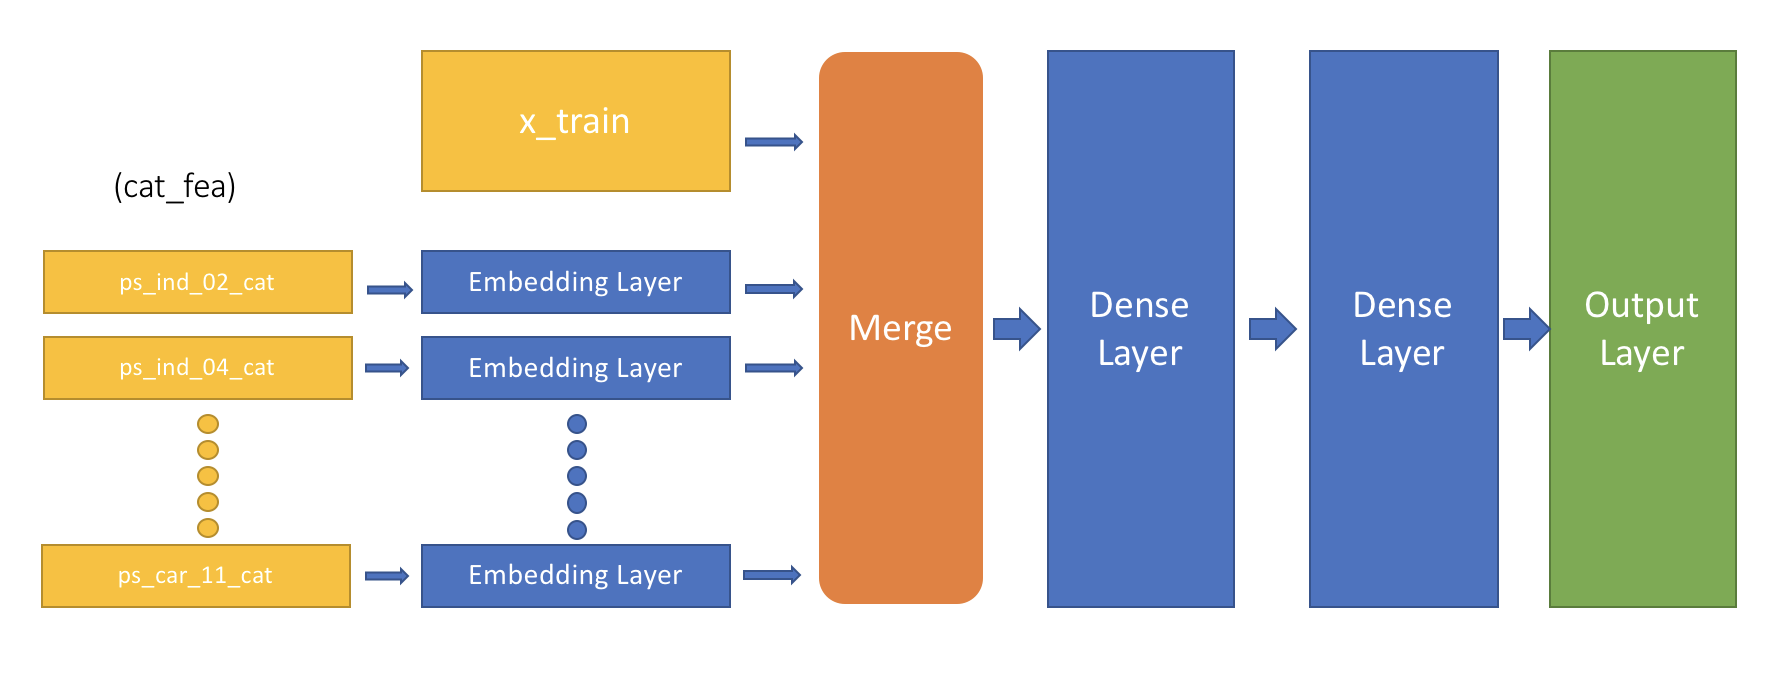

##### Input: 

* Các đặc trưng dạng Numerical(Gồm các đặc trưng dạng num có sẵn và đặc trưng sinh ra từ XBGboost predict)
* Đặc trưng dạng Categorical. Với những dạng đặc trưng dạng `cat`, ta đưa vào `Embedding layer` để chuyển các đặc trưng này về dạng vector có chiều quy định nhằm đồng nhất số chiều của các lớp. 
* Mỗi `cat` feature được đưa vào một `Embedding layer` riêng.




##### Layers:
* **Embedding**: Đưa các vector có số chiều lớn, thường là dữ liệu khả tách, về một vector có số chiều nhỏ hơn, thường ở dạng dày đặc. Làm cho các giá trị có ý nghĩa tương tự nhau nằm gần nhau trong không gian embedding. Các tham số của lớp embedding: input_dim = num_c + 1, output_dim, input_length. Các đặc trưng dạng Categorical được đưa vào lớp 

* **Merge**: chứa các layers giúp chúng ta cộng,trừ,hoặc nối các layer như các vector. Merge hai đặc trưng `Cat` và `Num` lại với nhau theo phương pháp `Concatenate`.
* **Dense**: layer này sử dụng như một layer neural network bình thường.
* **Output**: Là một `dense` layer với 1 node(nhận giá trị nhị phân)



##### Các siêu tham số cơ bản
- **Flatten**: dùng để lát phẳng layer để fully connection, vd : shape : 20x20 qua layer này sẽ là 400x1
- **Activation**: dùng để chọn activation trong layer
- **BatchNormalization**: chuẩn hóa các feature (đầu ra của mỗi layer sau khi đi qua các activation) về trạng thái zero-mean với độ lệch chuẩn 1. Đồng thời giúp tăng tốc độ học và chống overfiting.
- Dropout: layer này dùng như regularization cho các layer hạn chế overfiting.


In [ ]:
def nn_model():
    inputs = []
    flatten_layers = []
    for e, c in enumerate(cat_fea):
        input_c = Input(shape=(1, ), dtype='int32')
        num_c = max_cat_values[e]
        
        # **input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.**
        embed_c = Embedding(num_c+1,6,input_length=1)(input_c)
        embed_c = Dropout(0.25)(embed_c)
        flatten_c = Flatten()(embed_c)
        inputs.append(input_c)
        flatten_layers.append(flatten_c)
        
    input_num = Input(shape=(X.shape[1],), dtype='float32')
    inputs.append(input_num)
    
    #merge X and embedding layer
    flatten_layers.append(input_num)
    #flatten = merge(flatten_layers, mode='concat') 
    flatten = Concatenate()(flatten_layers)
    
    fc1 = Dense(512, kernel_initializer='he_normal')(flatten)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.75)(fc1)
    
    fc1 = Dense(64, kernel_initializer='he_normal')(fc1)
    fc1 = PReLU()(fc1)
    fc1 = BatchNormalization()(fc1)
    fc1 = Dropout(0.5)(fc1)

    outputs = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(fc1)

    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return (model)

#### Train

Phương pháp đánh giá mô hình: K-fold cross validation
* Xáo trộn tập dữ liệu và chia ra thành k tập (fold).
* Thực hiện k lần, mỗi lần sẽ sử dụng k - 1 fold để train và đánh giá trên fold còn lại. Như vậy k fold đều có thể thành tập test.
* Có k kết quả, sau khi kết thúc sẽ lấy kết quả dựa vào việc tổng hợp các kết quả.
* Kết quả thực nghiệm cho thấy k=5 hoặc k=10 cho ra kết quả tốt nhất.

In [ ]:
"""
#validation fold
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

I change "test" to "vaild" because I feel it is clear to understand
"""

cv_train = np.zeros(len(train_label))
cv_pred = np.zeros(len(test_id))

#validation fold
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=218)

#with different random see make result stable.
num_seeds = 5
begintime = time()
if cv_only:
    for s in range(num_seeds):
        np.random.seed(s)
        for (train_index, valid_index) in kfold.split(X, train_label):
            
            #assign data from training data and labels to validation data; 
            x_train = X[train_index]
            y_train = train_label[train_index]
            x_valid= X[valid_index]
            y_valid = train_label[valid_index]
            
            # assign X_cat to validation data; 
            x_train_cat = X_cat[train_index]
            x_valid_cat = X_cat[valid_index]

            #Package data for training, the package(list) is  [[cat_featrues], x_train] 
            # or [ ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat',.....,'ps_car_11_cat'] ,x_train]
            
            x_train_cat_list, x_valid_cat_list = [], []
            for i in range(x_train_cat.shape[1]):
                x_train_cat_list.append(x_train_cat[:, i].reshape(-1, 1))
                x_valid_cat_list.append(x_valid_cat[:, i].reshape(-1, 1))

            x_train_cat_list.append(x_train)
            x_valid_cat_list.append(x_valid)
            
            #load model
            model = nn_model()
            
            def get_rank(x):
                return pd.Series(x).rank(pct=True).values
            #fit model. Note: Change epochs to make prediction accuracy
            model.fit(x_train_cat_list, y_train, epochs=10, batch_size=512, verbose=2, validation_data=[x_valid_cat_list, y_valid])
            
            #record prediction with validation data
            cv_train[valid_index] += get_rank(model.predict(x=x_valid_cat_list, batch_size=512, verbose=0)[:, 0])
            print('local fold Gini: ',Gini(train_label[valid_index], cv_train[valid_index]))
            
            #recode prediction with testing data
            cv_pred += get_rank(model.predict(x=X_TEST_CAT, batch_size=512, verbose=0)[:, 0])
             
            
        
        print("seed {0}: Gini {1}".format(s,Gini(train_label, cv_train / (1. * (s + 1)))))
        print("Total training time: ",str(datetime.timedelta(seconds=time() - begintime)))
    if save_cv:
        
        #divid (NFOLDS * num_seeds) to get average of probablity 
        pd.DataFrame({'id': test_id, 'target': get_rank(cv_pred * 1./ (NFOLDS * num_seeds))}).to_csv('keras5_pred.csv', index=False)
        pd.DataFrame({'id': train_id, 'target': get_rank(cv_train * 1. / num_seeds)}).to_csv('keras5_cv.csv', index=False)



### Kế hoạch tiếp theo

* Tiếp tục tìm hiểu + train đặc trưng XGBoost
* Tìm hiểu + code mô hình LightGBM
* Tìm hiểu + code mô hình Neural networks
* Tìm hiểu các phương pháp để cải tiến solution

## Nhìn lại quá trình làm đồ án

## Tài liệu tham khảo